### We Choose XGB Due to Its Features Importance

In [1]:
import pandas as pd          
import numpy as np 
train_df = pd.read_csv("C:\\Users\\hp\\Desktop\\stroke-chatbot\\preprocessing\\01_Preprocessing\\train_encoded.csv")
test_df = pd.read_csv("C:\\Users\\hp\\Desktop\\stroke-chatbot\\preprocessing\\01_Preprocessing\\test_encoded.csv")


### XGB

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Data loaded from train_df/test_df ---
X_train shape: (232040, 30), X_test shape: (58011, 30)

Identified 0 remaining categorical features: []
Identified 30 numeric features (including your new target-encoded one)

--- Fitting preprocessor on X_train... ---
--- Data preprocessed. Total features: 30 ---

--- Starting Optuna Hyperparameter Tuning ---
--- Tuning Finished ---
Best trial AUC (CV mean): 0.976483
Best parameters found:
{'n_estimators': 372, 'learning_rate': 0.07012131809996036, 'max_depth': 10, 'subsample': 0.5196395939865119, 'colsample_bytree': 0.8708427278370471, 'gamma': 3.1735616001231657, 'reg_alpha': 0.013460845010990511, 'reg_lambda': 0.03154893505007707}

--- Starting Final Model Training ---
[0]	validation_0-auc:0.88729
[100]	validation_0-auc:0.98258
[200]	validation_0-auc:0.98559
[300]	validation_0-auc:0.98578
[371]	validation_0-auc:0.98589
--- Final Training Finished ---


     📈 XGBoost Model Evaluation (Tuned) 📈     

--- Key Metrics ---
Accuracy:  0.920291
P

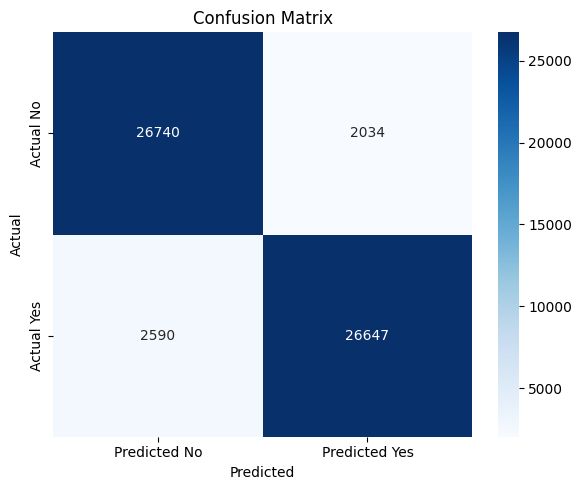


--- ROC Curve ---


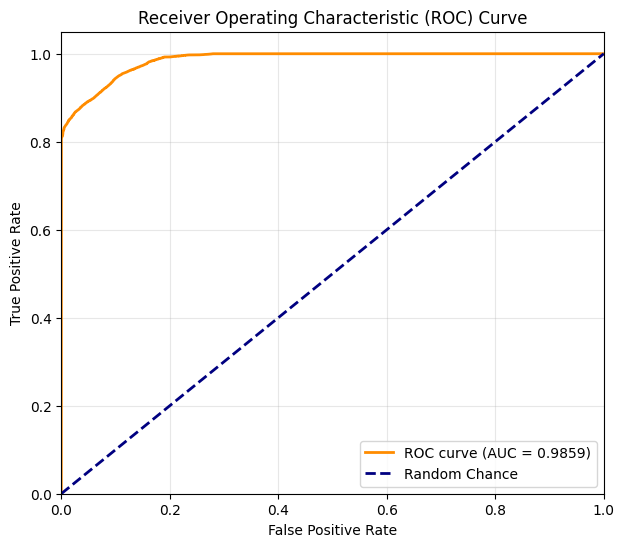


--- Feature Importance ---
Top 20 most important features:
family_history             0.177845
Family_Support_Impact      0.109933
Is_MidYear                 0.084743
care_options               0.081781
Country_TreatmentRate      0.056235
Hour                       0.052763
mental_health_interview    0.051559
Day                        0.050836
SelfEmployment_Risk        0.040248
Is_Winter                  0.039222
Year                       0.038857
Gender                     0.038662
Month                      0.036769
self_employed              0.036685
Is_Night                   0.028995
Coping_Struggles           0.027809
Occupation_Corporate       0.003693
Occupation_Others          0.003561
Changes_Habits             0.003537
Social_Function_Score      0.003519


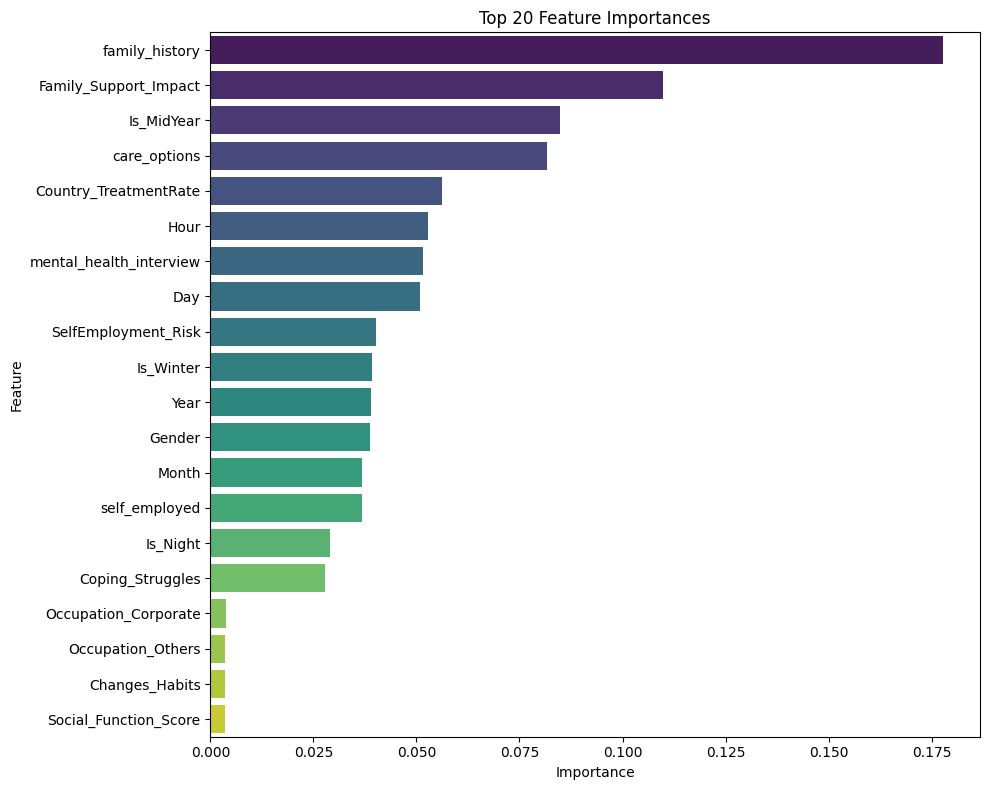


--- Evaluation Complete ---


In [2]:
# ============================================
# 🚀 XGBoost + Optuna (on Target-Encoded Data)
# ============================================
#
# This script is designed to run *after* your
# target-encoding snippet, using the 'train_df'
# and 'test_df' variables you created.
#
# ============================================

# ===== Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    roc_auc_score, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.pipeline import Pipeline
import optuna
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING) # Make Optuna quiet

# --- Global variable to hold preprocessor ---
# We'll fit this on X_train, then use it in the objective
preprocessor = None

# ============================================
# 1. Load and Validate Data
# ============================================

try:
    # Check if train_df and test_df exist from the prior cell
    if 'train_df' not in globals() or 'test_df' not in globals():
        raise NameError("train_df or test_df not found. Please run the target-encoding snippet first.")

    # --- Separate Features and Target ---
    X_train = train_df.drop(columns=['treatment'])
    y_train = train_df['treatment']
    
    X_test = test_df.drop(columns=['treatment'])
    y_test = test_df['treatment']

    print(f"--- Data loaded from train_df/test_df ---")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

except (NameError, ValueError) as e:
    print(f"ERROR: {e}")


# ============================================
# 2. Define Preprocessing Pipeline
# ============================================

# XGBoost can't handle raw strings. We must encode them.
# We will One-Hot Encode remaining categorical features and Scale numeric features.

# Identify remaining categorical and numeric columns from X_train
# (Country should be gone, but others like Gender, Occupation might be left)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

print(f"\nIdentified {len(categorical_features)} remaining categorical features: {categorical_features}")
print(f"Identified {len(numeric_features)} numeric features (including your new target-encoded one)")

# Create the preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# --- Apply Preprocessing ---
# Fit the preprocessor on X_train and transform both
print("\n--- Fitting preprocessor on X_train... ---")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing (for importance plot)
# This is a bit complex but very useful
ohe_feature_names = []
if categorical_features:
    try:
        # Get feature names from the 'onehot' step in the categorical_transformer
        ohe_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
    except Exception as e:
        print(f"Warning: Could not get OHE feature names. {e}")

# Combine all feature names
feature_names = numeric_features + ohe_feature_names
print(f"--- Data preprocessed. Total features: {len(feature_names)} ---")


# ============================================
# 3. Optuna Objective Function (using CV)
# ============================================

def objective(trial):
    # Define the hyperparameter search space for XGBoost
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    XGB = XGBClassifier(**params)
    
    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Run cross-validation
    scores = cross_val_score(
        XGB,
        X_train_processed, 
        y_train, 
        cv=skf, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    
    # Return the mean AUC
    return np.mean(scores)


print("\n--- Starting Optuna Hyperparameter Tuning ---")
# Create the study and run optimization

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=49))

study.optimize(objective, n_trials=50) # You can increase n_trials for better results

print("--- Tuning Finished ---")
print(f"Best trial AUC (CV mean): {study.best_value:.6f}")
print("Best parameters found:")
print(study.best_params)


# ============================================
# 4. Train Final Model with Best Parameters
# ============================================

# Get the best parameters found by Optuna
best_params = study.best_params

# Add/Update params for the final model
final_params = best_params.copy()
final_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'auc',
    # Use early stopping on the test set for the *final* model
    'early_stopping_rounds': 50 
})

final_XGB = XGBClassifier(**final_params)

print("\n--- Starting Final Model Training ---")
final_XGB.fit(
    X_train_processed, 
    y_train,
    eval_set=[(X_test_processed, y_test)],
    verbose=100
)
print("--- Final Training Finished ---")


# ============================================
# 5. Get Predictions
# ============================================

# Get class predictions (0 or 1)
y_pred = final_XGB.predict(X_test_processed)

# Get probability predictions (for ROC-AUC)
y_pred_proba = final_XGB.predict_proba(X_test_processed)[:, 1]


# ============================================
# 6. Comprehensive Evaluation
# ============================================

print("\n\n============================================")
print("     📈 XGBoost Model Evaluation (Tuned) 📈     ")
print("============================================")

# --- Individual Metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n--- Key Metrics ---")
print(f"Accuracy:  {acc:.6f}")
print(f"Precision: {prec:.6f}")
print(f"Recall:    {rec:.6f}")
print(f"F1-Score:  {f1:.6f}")
print(f"ROC–AUC:   {roc_auc:.6f}")

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, digits=4))

# --- Confusion Matrix Plot ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- ROC Curve Plot ---
print("\n--- ROC Curve ---")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# ============================================
# 7. Feature Importance
# ============================================

print("\n--- Feature Importance ---")
try:
    # Create a series of feature importances
    fi_series = pd.Series(final_XGB.feature_importances_, index=feature_names)
    fi_series_sorted = fi_series.sort_values(ascending=False)
    
    print("Top 20 most important features:")
    print(fi_series_sorted.head(20).to_string())

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_series_sorted.head(20).values, y=fi_series_sorted.head(20).index, palette='viridis')
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not plot feature importance: {e}")


print("\n--- Evaluation Complete ---")


In [3]:
import joblib

# حفظ الموديل الذي تم تحسينه
joblib.dump(final_XGB, 'health_chatbot_model.joblib')

# حفظ محول الأعمدة (PreProcessor) لأنه ضروري لمعالجة أي بيانات جديدة
joblib.dump(preprocessor, 'data_preprocessor.joblib')

print("Model and Preprocessor saved to files.")

Model and Preprocessor saved to files.
